# Hypothesis Testing with Insurance Data (Core)

For this assignment, we will be working with the US Health Insurance Dataset from Kaggle.

We have been asked to use our hypothesis testing skills to answer the following questions:

- Q1. Do smokers have higher insurance charges than non-smokers?
- Q2. Are men more likely to smoke than women?
- Q3. Do different regions have different charges, on average?


For each question, make sure to:

    State your Null Hypothesis and Alternative Hypothesis
    Select the correct test according to the data type and number of samples
    Test the assumptions of your selected test.
    Execute the selected test, or the alternative test (if you do not meet the assumptions)
    Interpret your p-value and reject or fail to reject your null hypothesis 
    Show a supporting visualization that helps display the result

In [1]:
import pandas as pd
import numpy as np
import matplotlib.pyplot as plt
import seaborn as sns
import scipy.stats as stats
from statsmodels.stats.multicomp import pairwise_tukeyhsd


In [2]:
df = pd.read_csv('insurance.csv')
df.head()

,age,sex,bmi,children,smoker,region,charges
0,19,female,27.900,0,yes,southwest,16884.92400
1,18,male,33.770,1,no,southeast,1725.55230
2,28,male,33.000,3,no,southeast,4449.46200
3,33,male,22.705,0,no,northwest,21984.47061
4,32,male,28.880,0,no,northwest,3866.85520


# Q1. Do smokers have higher insurance charges than non-smokers?

## State your Null Hypothesis and Alternative Hypothesis

Null: There is no significant difference in insurance charges whether or not the person is a smoker.

Alternative: Smokers do, in fact, have higher insurance charges.

## Select the correct test according to the data type and number of samples

Numeric with 2 groups, so a 2 Sample T-Test.

## 3. Test the assumptions of your selected list.

### Check for and remove outliers

In [6]:
# see how many smoke or don't smoke
df['smoker'].value_counts()


no     1064
yes     274
Name: smoker, dtype: int64

In [7]:
# Filtering out those who do or don't smoke
smoker_df = df.loc[df['smoker']== 'yes'].copy()
nonsmoker_df = df.loc[df['smoker']== 'no'].copy()

In [10]:
smoker_charges = smoker_df['charges']
nonsmoker_charges = nonsmoker_df['charges']

In [9]:
# Check for outliers in charge for smoker
zscores= stats.zscore(smoker_charges)
outliers = abs(zscores)>3
np.sum(outliers)


0

In [11]:
# check for outliers in charge for non smoker
zscores= stats.zscore(nonsmoker_charges)
outliers = abs(zscores)>3
np.sum(outliers)


24

In [12]:
# remove outlier for non smokers
nonsmoker_charges = nonsmoker_charges[(np.abs(stats.zscore(nonsmoker_charges)) < 3)]

### Check for Normality

In [14]:
# test the strength group for normality
result_smoker_charges = stats.normaltest(smoker_charges)
result_smoker_charges

NormaltestResult(statistic=61.03941356533816, pvalue=5.564930630036463e-14)

In [15]:
result_nonsmoker_charges = stats.normaltest(nonsmoker_charges)
result_nonsmoker_charges


NormaltestResult(statistic=163.80367047789198, pvalue=2.6945416315543976e-36)

Our p-values for both group are well below 0.05 which means our data is NOT normally distributed. However, our our sample size is large enough to proceed without satisfying this test. For an independent t test, sample sizes of 15 per group are considered sufficient.


### Check for Equal Variance

In [16]:
# Test for equal variance
result = stats.levene(smoker_charges, nonsmoker_charges)
result

LeveneResult(statistic=520.7468821724297, pvalue=2.4247238784347824e-97)

Looks like we don't have equal variances

## Execute the selected test

In [17]:
# Independent t-test with equal_var set to False
result = stats.ttest_ind(smoker_charges, nonsmoker_charges, equal_var = False)
result

Ttest_indResult(statistic=33.732305987092516, pvalue=2.575322662587431e-104)

## Interpret your p-value and reject or fail to reject your null hypothesis 

Our p value < alpha (0.05), so we reject the null hypothesis and accept that there is a significant difference

## Show a supporting visualization that helps display the result

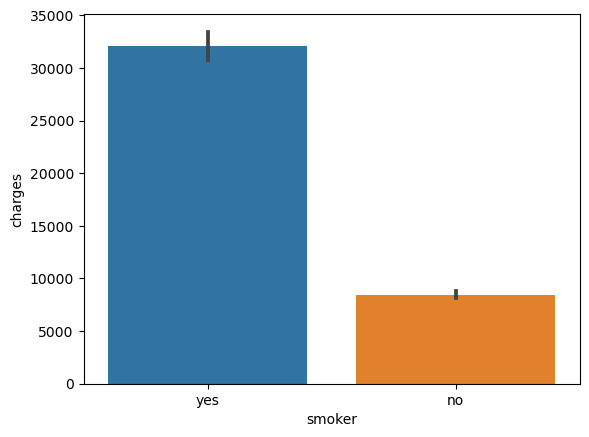

In [18]:
## Barplot
sns.barplot(data=df, x='smoker',y='charges')
fig.suptitle('Comparison of charges by Smoker',fontsize='xx-large');

# Q2. Are men more likely to smoke than women?

##  State your Null Hypothesis and Alternative Hypothesis

Null: There is no higher or lower likely-hood for smoking by sex.

Alternate: Men are, in fact more likely to smoke than women.

## Select the correct test according to the data type and number of samples

In [19]:
# see value count by sex
df['sex'].value_counts()

male      676
female    662
Name: sex, dtype: int64

Two categories and two outcomes, so we will run a Chi-Squared Test

## Test the assumptions of your selected test.

In [20]:
# calculate the contingency table with pd.cross-tab
table = pd.crosstab(df['sex'], df['smoker'])
table

smoker,no,yes
sex,,
female,547,115
male,517,159


### contingency table with pd.cross-tab

In [21]:
# Run the Test and Save the Output
result = stats.chi2_contingency(table)
chi2, p, deg_free, expected_vals = result #this labels the results

## Execute the selected test

In [22]:
# What was our p-value?
print(p)
p<.05


0.006548143503580696


True

## Interpret your p-value and reject or fail to reject your null hypothesis

P value is less than .05 so we have a significant result. 

We reject the null hypothesis and accept the alternate that these is a relationship between sex and being a smoker.

## Show a supporting visualization that helps display the result

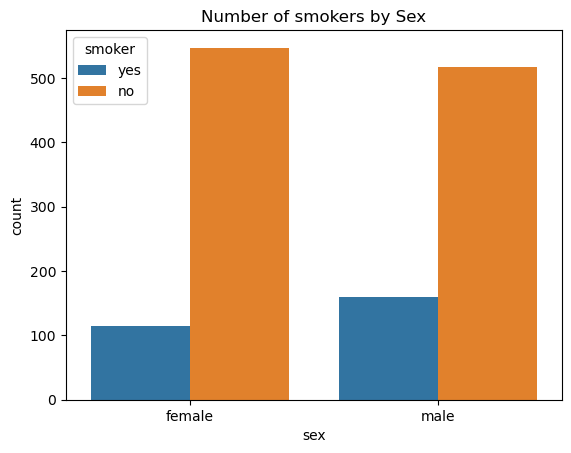

In [25]:
ax = sns.countplot(data=df, x='sex',hue='smoker',)
ax.set_title("Number of smokers by Sex");

# Q3. Do different regions have different charges, on average?

## 1. State your Null Hypothesis and Alternative Hypothesis

Null Hypothesis: Different regions have the same results.

Alternative Hypothesis: Different regions have different results.

Using an alpha=.05

## 2. Select the correct test according to the data type and number of samples

Numerical data for more than two groups, so one way ANOVA

In [27]:
## Create groups dictionary. There are only 3 groups, but this is even more helpful when there are many groups
groups = {}
## Loop through all unique categories
for i in df['region'].unique():
    ## Get series for group and rename
    data = df.loc[df['region']==i,'charges'].copy()
    
    # save into the dictionary
    groups[i] = data
groups.keys()


dict_keys(['southwest', 'southeast', 'northwest', 'northeast'])

##  3. Test the assumptions of your selected test.

One Way ANOVA

Normality

Equal variance

No significant outliers


### Check for normality

In [28]:
## Running normal test on each group and confirming there are >20 in each group
norm_results = {}
for i, data in groups.items():
    stat, p = stats.normaltest(data)
    ## save the p val, test statistic, and the size of the group
    norm_results[i] = {'n': len(data),
                             'p':p,
                             'test stat':stat,}
## convert to a dataframe
norm_results_df = pd.DataFrame(norm_results).T
norm_results_df


,n,p,test stat
southwest,325.0,6.125298e-23,102.294059
southeast,364.0,4.953297e-15,65.877446
northwest,325.0,5.184209e-24,107.232850
northeast,324.0,1.455431e-19,86.747629


### Check for significance

In [29]:
### checking sig with pandas 
norm_results_df['sig'] = norm_results_df['p'] < .05 
norm_results_df

,n,p,test stat,sig
southwest,325.0,6.125298e-23,102.294059,True
southeast,364.0,4.953297e-15,65.877446,True
northwest,325.0,5.184209e-24,107.232850,True
northeast,324.0,1.455431e-19,86.747629,True


There are significant outliers, we will need to run a Nonparamentric test.

### Check for Equal Variance

In [31]:
# with the * operator 
stats.levene(*groups.values())

LeveneResult(statistic=5.559966758410606, pvalue=0.0008610590250786703)

Variance is less than .05 so we do not have equal variances, confirming we need a Nonparamentric test.

## 4. Execute the selected test (NonParametric)

In [30]:
from scipy import stats



In [35]:
stats.kruskal(*groups.values())

KruskalResult(statistic=4.734181215658743, pvalue=0.19232908072121002)

The p value is > alpha so it would seem the null hypothesis will fail to be rejected, but we will run a multiple comparison test.

In [38]:
from statsmodels.stats.multicomp import pairwise_tukeyhsd
## save the values as charges and labels as region
values = df['charges']
labels = df['region']

In [39]:
## perform tukey's multiple comparison test and display the summary
tukeys_results = pairwise_tukeyhsd(values,labels)
tukeys_results.summary()

group1,group2,meandiff,p-adj,lower,upper,reject
northeast,northwest,-988.8091,0.7245,-3428.9343,1451.3161,False
northeast,southeast,1329.0269,0.4745,-1044.9417,3702.9955,False
northeast,southwest,-1059.4471,0.6792,-3499.5723,1380.6781,False
northwest,southeast,2317.8361,0.0583,-54.1994,4689.8716,False
northwest,southwest,-70.638,0.9999,-2508.8826,2367.6066,False
southeast,southwest,-2388.4741,0.0477,-4760.5096,-16.4386,True


We fail to reject 5 out of the 6 hypotheses, so we will choose to fail to reject the null hypothesis.

##  5. Interpret your p-value and reject or fail to reject your null hypothesis 

P value is > alpha so we fail to reject null hypothesis.

Southeast and SouthWest had significant differences in results, but the groups as a whole mostly had insignificant differences.

##   6. Show a supporting visualization that helps display the result

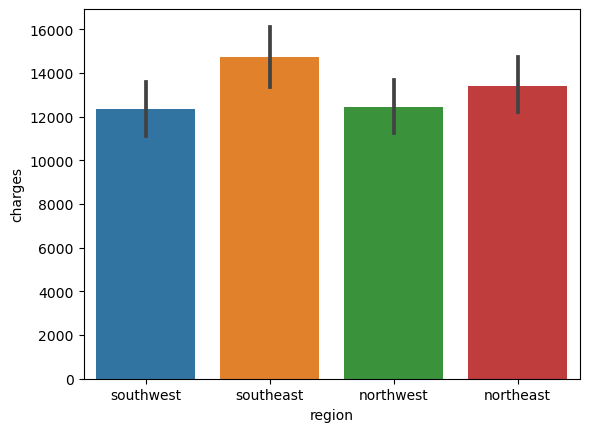

In [26]:
sns.barplot(data=df, x='region',y='charges');